Before running this notebook, remember to create a **shortcut of the data** in your Drive and then **mount the Google Drive**. <br>You may also want to **create a copy** of this notebook and put it in your individual folder.<br>For more details, refer to this quick start video. 

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import pandas.testing as tm
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.preprocessing import RobustScaler

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [ ]:
df = pd.read_csv('/content/drive/My Drive/census_1910_manhattan.csv', low_memory=False)
regression_df = pd.read_csv('/content/drive/My Drive/regression_df_1910.csv')

In [ ]:
# -----------------------------Correlation & Regression------------------------------------------

def show_corr(cols ,data=regression_df):

  if isinstance(cols,str):
    cols = cols.strip().split()
  try:
    corr_df = data[cols].copy().corr()
  except KeyError as e:
    print('Variable "'+re.findall(r"\[\'(.*?)\'\]", str(e))[0]+'" not found, check your spelling please.')
    return 
    
  cmap=sns.diverging_palette(10, 130, as_cmap=True) # red green

  corr = corr_df.values
  np.fill_diagonal(corr, np.nan)
  corr = np.triu(corr,k=1)
  corr[corr == 0] = np.nan
  labels = corr_df.columns

  plt.figure(figsize=(5,4),dpi=120)
  sns.heatmap(corr, cmap=cmap, center = 0, annot=True, xticklabels=labels, yticklabels=labels)


def run_regression(design, data = regression_df):
  variables = design.replace('~',' ').replace('+',' ').split()
  selected_data = data[variables].copy()
  scaled_data = pd.DataFrame(RobustScaler().fit_transform(X=selected_data), columns = selected_data.columns)
  y, X = dmatrices(design, data = scaled_data, return_type='dataframe')   # Split data columns
  mod = sm.OLS(y, X)
  res = mod.fit()
  print(res.summary())

# -------------------------------------Data Selection----------------------------------------------

def build_criteria_from_string(string, data):
  string = string.replace(' is ',' = ')
  col = string.split('=')[0].strip()
  value = string.split('=')[1].strip()
  value = int(value) if value.isnumeric() else value
  return build_criteria(col, value, data)

def build_criteria(col, value, data):
  return data[col]==value

def get_multiple_criteria(string, data):
  multiple_criteria= [c.strip() for c in string.split(',')]
  multiple_criteria = [c+' = 1' if (' = ' not in c) and (' is ' not in c) and (c in data.columns) else c for c in multiple_criteria]
  multiple_criteria_filters = [build_criteria_from_string(c, data) for c in multiple_criteria]
  combined_filter = pd.Series([True]*len(data))
  for filter in multiple_criteria_filters:
    combined_filter = combined_filter & filter
  return combined_filter

def select_data(criteria_string, data):
  criteria_filter = get_multiple_criteria(criteria_string, data)
  return data[criteria_filter].copy()

# -------------------------------------Smart Data Description-------------------------------------------

def describe(col, data = df, top_k = -1, thres = 90, return_full = False, plot_top_k = -1, plot_type = '', bins= -1):
  
  if data[col].isnull().mean()>0:
    print(f"Notice: {np.round(data[col].isnull().mean()*100,3)}% of the entries have no records for this field.\n")

  data_numeric_columns = data.dtypes[data.dtypes.apply(lambda x: np.issubdtype(x, np.number))].index.tolist()

  if col in data_numeric_columns:
    if bins == -1:
      print(f'Change the default width of histogram bars by setting "bins = <a number>".\n')
      bins = 50
    plt.figure(figsize=(9, 6), dpi=120)
    plt.hist(data[col].dropna(),bins=bins)
    plt.title(f"Distribution of the {col}")
    return 

  ser = data[col].value_counts()
  ser.name = 'Absolute Number'

  percentage_ser = np.round(ser/len(data)*100,2)
  percentage_ser.name = 'Proportion in Data (%)'

  cumsum_percentage_ser = percentage_ser.cumsum()
  cumsum_percentage_ser.name = 'Cumulative Proportion (%)'

  full_value_counts_df = pd.concat([ser,percentage_ser,cumsum_percentage_ser],axis=1)

  if plot_top_k>top_k:
    top_k = plot_top_k

  if top_k == -1:
    top_k = sum(cumsum_percentage_ser<=thres)+1
    top_k = max(5,top_k)
    top_k = min(20,top_k)

  value_counts_df = full_value_counts_df if return_full else full_value_counts_df[:top_k]

  if top_k<len(full_value_counts_df) and not return_full:
    print(f'{len(full_value_counts_df)-top_k} more rows are available, add "return_full = True" if you want to see all.\n')

  plot_top_k = 10 if plot_top_k == -1 else plot_top_k
  graph_df = value_counts_df['Proportion in Data (%)'][:plot_top_k].copy()

  if plot_type == '':
    plot_type = 'bar' if graph_df.sum()<thres else 'pie'

  if plot_type == 'pie':

    fig, ax = plt.subplots(figsize=(9, 6), dpi=120, subplot_kw = dict(aspect="equal"))

    values = graph_df.values.tolist()
    names = graph_df.index.tolist()

    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%".format(pct, absolute)

    wedges, texts, autotexts = ax.pie(values,autopct=lambda pct: func(pct, values),textprops=dict(color="w"))

    for w in wedges:
        w.set_edgecolor('white')

    ax.legend(wedges, names,
              title= "Categories",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.8, 1))

    plt.setp(autotexts, size=12, weight="bold")

    ax.set_title(f"Relative Proportion of Top {len(graph_df)} {col}" if len(graph_df)<len(full_value_counts_df) else f"Proportion of {col}")

  if plot_type == 'bar':
    plt.figure(figsize=(9, 6), dpi=120)
    graph_df.plot(kind='bar')
    plt.title(f"Barplot of the Top {len(graph_df)} {col} - (y axis shows percentage)")
  
  print()

  return value_counts_df


##**Description of available variables in regression_df**


**Name related:**
  - `first_name_popularity `
  - `surname_popularity`
  - `middle_name_non_blank`

*Popularity is the logarithm of the number of occurrence of the name, larger number indicates greater popularity; <br> The field middle_name_non_blank is 1 if the person has middle name recorded and 0 otherwise.*

**Population density related:**
  - `household_size`
  - `unique_dwelling_number_at_this_address`
  - `unique_householdid_at_this_address`
  - `unique_recordid_at_this_address`

*The household_size field is the number of people with that same household ID; <br> The other three are the numbers of unique dwellings / households / individuals at a specific address.*

**Property related:**
  - `own_dwelling`

*The own_dwelling field is 1 if the household that the person belongs to owns the dwelling that they live in.*

**Gender related:**
  - `is_female`

*The is_female field will be 1 if the person is a female and 0 if male.*

**Age related:**
  - `age`

*The age field is just what it means. However, in the raw data there are cases where the reported age shows potential conflicts with other fields, e.g. a person is young but has children. These cases have been partially cleaned through rules, but may persist in other cases.*

**Race related:**
  - `race__black`
  - `race__chinese`
  - `race__mulatto`
  - `race__other`
  - `race__white`
  - `race__nan`

*The variables that share common prefix and has '\_\_' in the middle are results of one-hot encoding. If a person is chinese, his/her 'race\_\_chinese' variable will take the value of 1, while his/her other variables will all be 0.*

**Literacy related:**
  - `can_read`
  - `can_write`
  - `attended_school`

*Dummy variables for the three fields. For example, a person's can_read field is 1 if he/she can read and 0 otherwise.*

**Disabilities related:**
  - `is_blind`
  - `is_deaf_and_dumb`

*Dummy variables, similar to the above. Note, however, that undocumented entries for these fields are treated as no disabilities.*


**Relationship with the head of household:**
  - `relationship__head`
  - `relationship__wife`
  - `relationship__brother`
  - `relationship__brother_in_law`
  - `relationship__sister`
  - `relationship__sister_in_law`
  - `relationship__son`
  - `relationship__daughter`
  - `relationship__cousin`  
  - `relationship__guest`
  - `relationship__servant`
  - `relationship__boarder`
  - `relationship__lodger`
  - `relationship__inmate`
  - `relationship__other`
  - `relationship__nan`

*Above are one-hot encoding of the relationship field. If a person's relationship with the head of household is 'brother', then his variable 'relationship__brother' will be 1, and all other variables listed above will be 0.*

**Marriage and offspring related:**
  - `marital_status__divorced`
  - `marital_status__married`
  - `marital_status__single`
  - `marital_status__widowed`
  - `marital_status__nan`
  - `number_of_years_of_present_marriage`
  - `number_of_children_born`
  - `number_of_children_living`

*The field number_of_years_of_present_marriage is 0 for currently non-married people (single, widowed, divorced); <br> The value of number_of_children_born must be greater than the value of number_of_children_living, and they need to fall in a reasonable range according to the parents' age. These two fields are cleaned through rules.*

**Employment related:**
  - `self_employed_or_not__employer`
  - `self_employed_or_not__own_account`
  - `self_employed_or_not__wage_earner`
  - `self_employed_or_not__nan`
  - `out_of_work_on_april_15`
  - `number_of_weeks_out_of_work`
  - `percentage_of_people_working_in_household`

*First four fields are one-hot encoding of the field self_employed_or_not; <br> The field out_of_work_on_april_15 is a dummy variable (1 or 0), number_of_weeks_out_of_work indicates the duration of unemployment; <br> The percentage_of_people_working_in_household is calculated by dividing the number of people in a household that have documented occupations with the total number of people in that household.*

**Occupation related:**
  - `occupation_score`
  - `has_occupation_score`
  - `average_occupation_score_among_all_members_of_household`
  - `average_occupation_score_among_working_members_of_household`

*Occupation score is a constructed variable that assigns occupational income scores to each occupation. The occupation_score here is estimated based on the OCCSCORE published at IPUMS USA, and customized through LDA topic modeling. For the description of the original OCCSCORE, visit [the IPUMS website](https://usa.ipums.org/usa-action/variables/OCCSCORE#description_section).<br> The field has_occupation_score is a dummy variable indicating whether a person has his/her own occupation score available; <br> The average occupation_score is then calculated with all members as denominator and working members as denominator.*


**Immigration related:**
  - `naturalization_status__alien`
  - `naturalization_status__inapplicable`
  - `naturalization_status__naturalized`
  - `naturalization_status__papers`
  - `naturalization_status__nan`
  - `how_many_years_in_us`

*One-hot encoding, the field naturalization_status__inapplicable means the person is born within the U.S., so he/she is an American citizen by birth, and naturalization status is not applicable. <br> The field how_many_years_in_us shows either how long an immigrant had spent in the U.S. or the age if the person was born in the U.S.*


**Language related:**
  - `self_native_tongue__english`
  - `self_native_tongue__italian`
  - `self_native_tongue__other`
  - `self_native_tongue__unknown`
  - `self_native_tongue__yiddish`
  - `self_native_tongue__nan`

**Birthplace related:**
  - `birthplace__austria`
  - `birthplace__canada`
  - `birthplace__england`
  - `birthplace__france`
  - `birthplace__germany`
  - `birthplace__greece`
  - `birthplace__hungary`
  - `birthplace__ireland`
  - `birthplace__italy`
  - `birthplace__massachusetts`
  - `birthplace__new_jersey`
  - `birthplace__new_york`
  - `birthplace__other`
  - `birthplace__pennsylvania`
  - `birthplace__romania`
  - `birthplace__russia`
  - `birthplace__scotland`
  - `birthplace__us`
  - `birthplace__virginia`
  - `birthplace__nan`
  - `fathers_birthplace__austria`
  - `fathers_birthplace__canada`
  - `fathers_birthplace__england`
  - `fathers_birthplace__france`
  - `fathers_birthplace__germany`
  - `fathers_birthplace__greece`
  - `fathers_birthplace__hungary`
  - `fathers_birthplace__ireland`
  - `fathers_birthplace__italy`
  - `fathers_birthplace__massachusetts`
  - `fathers_birthplace__new_jersey`
  - `fathers_birthplace__new_york`
  - `fathers_birthplace__other`
  - `fathers_birthplace__pennsylvania`
  - `fathers_birthplace__romania`
  - `fathers_birthplace__russia`
  - `fathers_birthplace__scotland`
  - `fathers_birthplace__sweden`
  - `fathers_birthplace__virginia`
  - `fathers_birthplace__nan`
  - `mothers_birthplace__austria`
  - `mothers_birthplace__canada`
  - `mothers_birthplace__england`
  - `mothers_birthplace__france`
  - `mothers_birthplace__germany`
  - `mothers_birthplace__greece`
  - `mothers_birthplace__hungary`
  - `mothers_birthplace__ireland`
  - `mothers_birthplace__italy`
  - `mothers_birthplace__massachusetts`
  - `mothers_birthplace__new_jersey`
  - `mothers_birthplace__new_york`
  - `mothers_birthplace__other`
  - `mothers_birthplace__pennsylvania`
  - `mothers_birthplace__romania`
  - `mothers_birthplace__russia`
  - `mothers_birthplace__scotland`
  - `mothers_birthplace__sweden`
  - `mothers_birthplace__virginia`
  - `mothers_birthplace__nan`

*One-hot encoding for three fields: the person's own birthplace, and the birthplaces of the parents of the person.*

Notice: 0.003% of the entries have no records for this field.

110 more rows are available, add "return_full = True" if you want to see all.




,Absolute Number,Proportion in Data (%),Cumulative Proportion (%)
New York,414221,40.03,40.03
Russia,179986,17.39,57.42
Italy,135439,13.09,70.51
Austria,84544,8.17,78.68
Ireland,43858,4.24,82.92
Germany,35979,3.48,86.40
Hungary,28011,2.71,89.11
Romania,15372,1.49,90.60


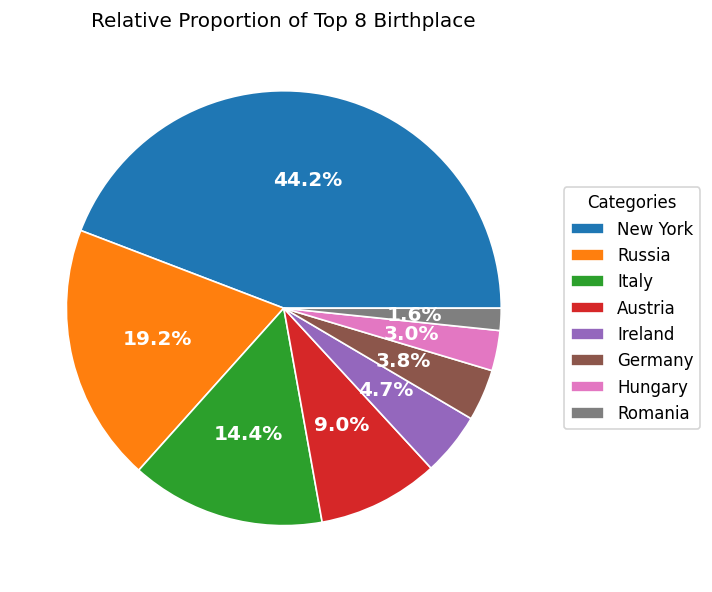

In [ ]:
describe("Birthplace")

Notice: 49.875% of the entries have no records for this field.

25372 more rows are available, add "return_full = True" if you want to see all.




,Absolute Number,Proportion in Data (%),Cumulative Proportion (%)
Operator,32778,3.17,3.17
Laborer,28412,2.75,5.92
Tailor,21049,2.03,7.95
Clerk,17756,1.72,9.67
Salesman,16936,1.64,11.31
Dress Maker,11992,1.16,12.47
Driver,11761,1.14,13.61
Finisher,9291,0.90,14.51
Presser,8889,0.86,15.37
Waiter,7727,0.75,16.12


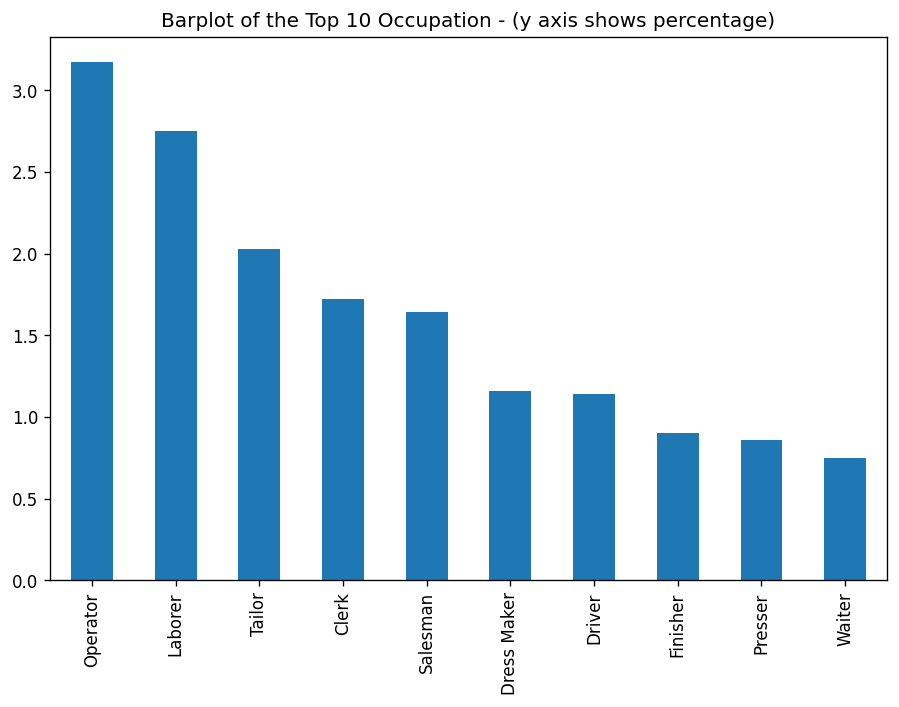

In [ ]:
describe("Occupation")

Change the default width of histogram bars by setting "bins = <a number>".



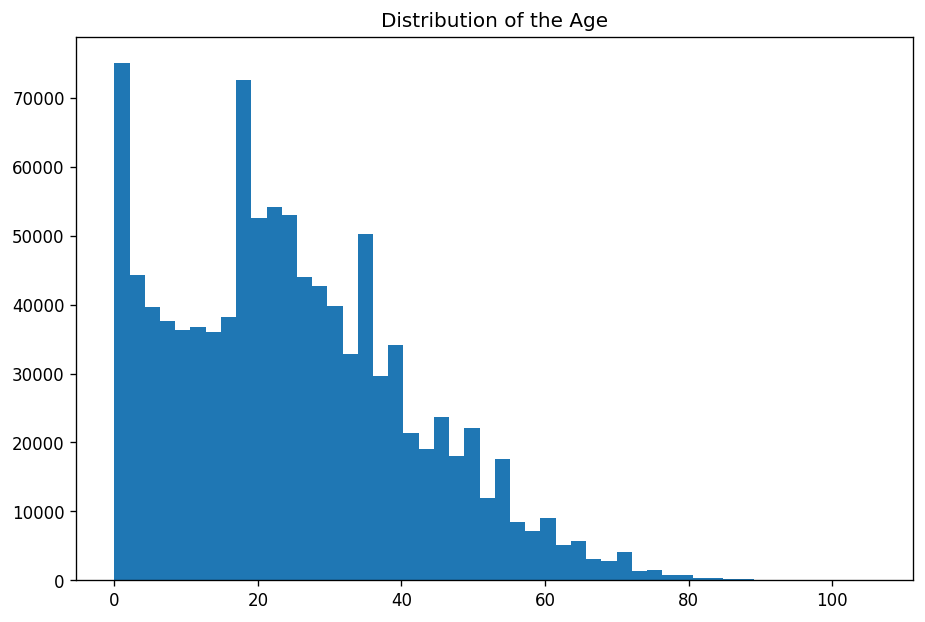

In [ ]:
describe("Age")

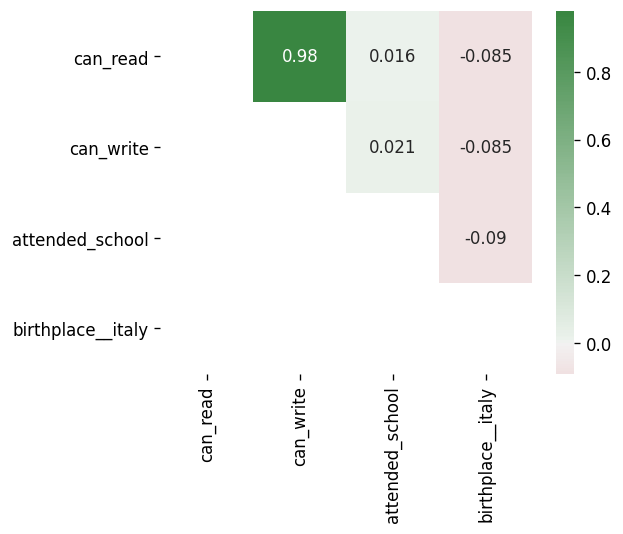

In [ ]:
show_corr('can_read can_write attended_school birthplace__italy')

In [ ]:
design = 'average_occupation_score_among_working_members_of_household ~ age + can_read + birthplace__russia + is_female'
run_regression(design)

                                                 OLS Regression Results                                                
Dep. Variable:     average_occupation_score_among_working_members_of_household   R-squared:                       0.015
Model:                                                                     OLS   Adj. R-squared:                  0.015
Method:                                                          Least Squares   F-statistic:                     4057.
Date:                                                         Sat, 10 Oct 2020   Prob (F-statistic):               0.00
Time:                                                                 08:01:40   Log-Likelihood:            -1.3523e+06
No. Observations:                                                      1034722   AIC:                         2.705e+06
Df Residuals:                                                          1034717   BIC:                         2.705e+06
Df Model:                               

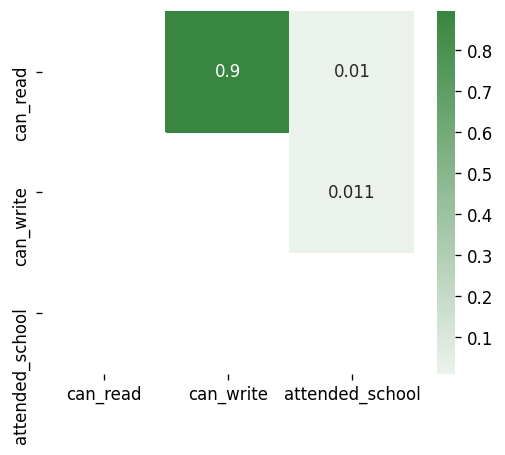

In [ ]:
data_1 = select_data('Occupation is Cook, is_female, mothers_birthplace__ireland', regression_df)
show_corr('can_read can_write attended_school', data_1)

In [ ]:
design = 'average_occupation_score_among_working_members_of_household ~ age + can_read + marital_status__married'
data_2 = select_data('is_female, race__white', regression_df)
run_regression(design, data_2)

                                                 OLS Regression Results                                                
Dep. Variable:     average_occupation_score_among_working_members_of_household   R-squared:                       0.001
Model:                                                                     OLS   Adj. R-squared:                  0.001
Method:                                                          Least Squares   F-statistic:                     172.8
Date:                                                         Sat, 10 Oct 2020   Prob (F-statistic):          5.56e-112
Time:                                                                 08:01:42   Log-Likelihood:            -6.3543e+05
No. Observations:                                                       489664   AIC:                         1.271e+06
Df Residuals:                                                           489660   BIC:                         1.271e+06
Df Model:                               

In [ ]:
data_3 = select_data('is_female, race__black', regression_df)
run_regression(design, data_3)

                                                 OLS Regression Results                                                
Dep. Variable:     average_occupation_score_among_working_members_of_household   R-squared:                       0.011
Model:                                                                     OLS   Adj. R-squared:                  0.010
Method:                                                          Least Squares   F-statistic:                     22.54
Date:                                                         Sat, 10 Oct 2020   Prob (F-statistic):           1.63e-14
Time:                                                                 08:01:42   Log-Likelihood:                -8704.1
No. Observations:                                                         6346   AIC:                         1.742e+04
Df Residuals:                                                             6342   BIC:                         1.744e+04
Df Model:                               

,Absolute Number,Proportion in Data (%),Cumulative Proportion (%)
Male,535997,51.8,51.8
Female,498725,48.2,100.0


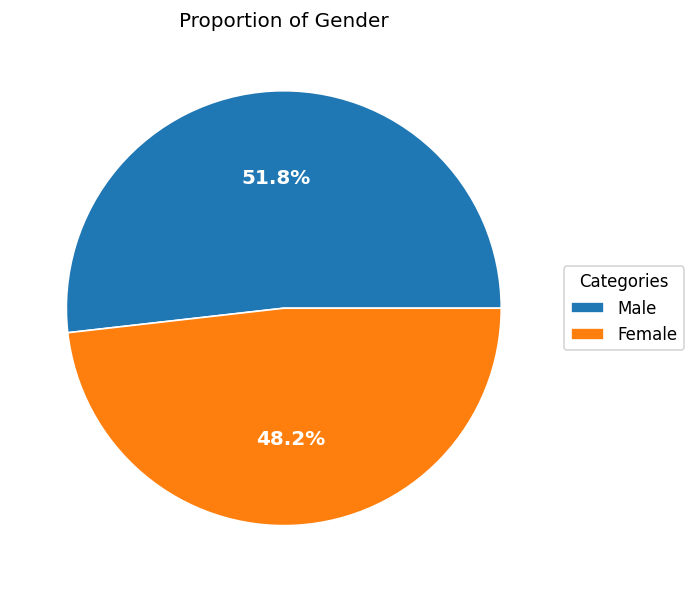

In [ ]:
describe('Gender')

Notice: 0.019% of the entries have no records for this field.

10 more rows are available, add "return_full = True" if you want to see all.




,Absolute Number,Proportion in Data (%),Cumulative Proportion (%)
White,1015020,98.10,98.10
Black,12096,1.17,99.27
Mulatto,4576,0.44,99.71
Chinese,2402,0.23,99.94
Japanese,126,0.01,99.95


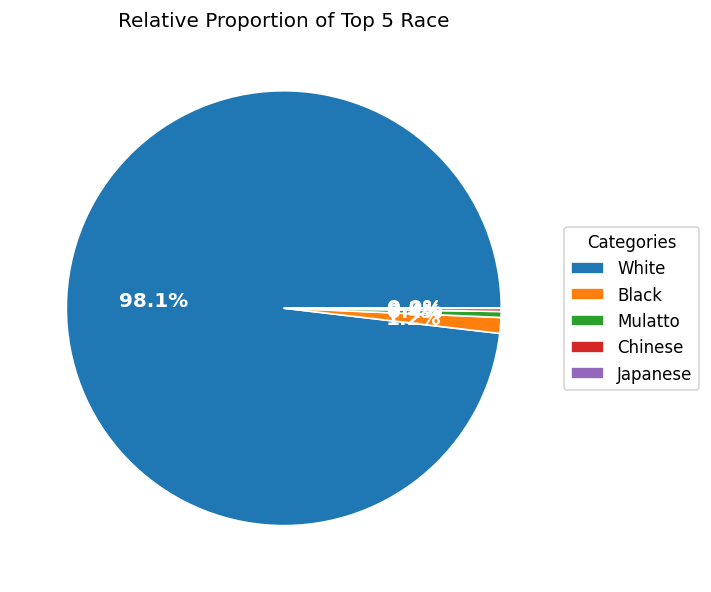

In [ ]:
describe('Race')

Notice: 0.019% of the entries have no records for this field.




,Absolute Number,Proportion in Data (%),Cumulative Proportion (%)
White,1015020,98.10,98.10
Black,12096,1.17,99.27
Mulatto,4576,0.44,99.71
Chinese,2402,0.23,99.94
Japanese,126,0.01,99.95
Filipino,121,0.01,99.96
Colored,77,0.01,99.97
Indian,46,0.00,99.97
Mexican,27,0.00,99.97
Octoroon,10,0.00,99.97


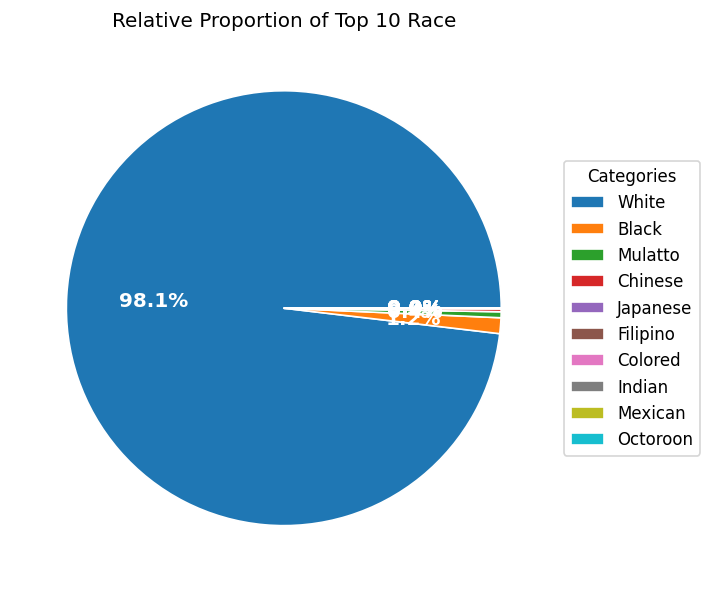

In [ ]:
describe('Race', return_full=True)

Change the default width of histogram bars by setting "bins = <a number>".



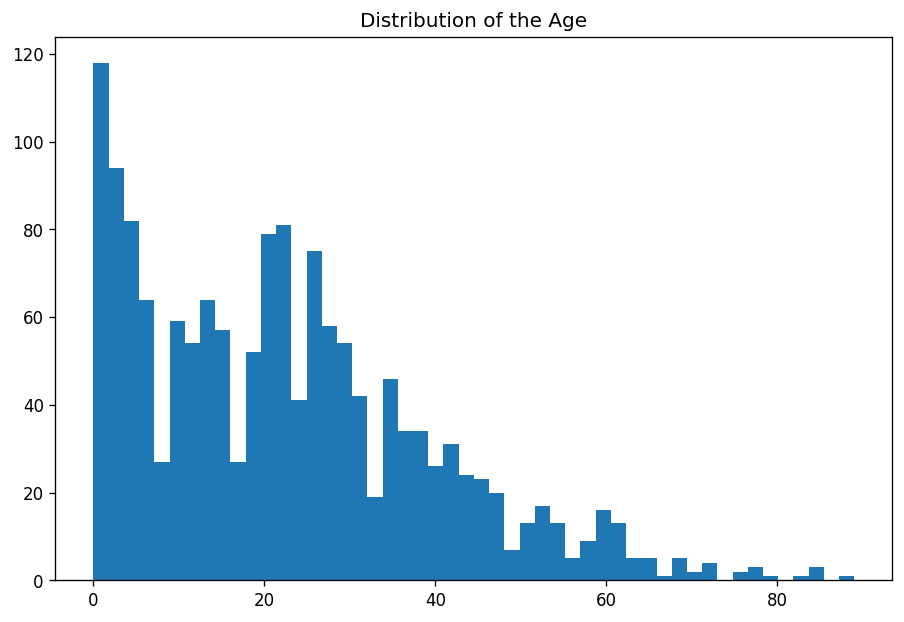

In [ ]:
data_4 = select_data('Gender is Female, Race is Black, Birthplace is New York', df)
describe("Age", data_4)

Notice: 58.968% of the entries have no records for this field.

83 more rows are available, add "return_full = True" if you want to see all.




,Absolute Number,Proportion in Data (%),Cumulative Proportion (%)
Launderer,129,8.54,8.54
Servant,66,4.37,12.91
Maid,60,3.97,16.88
House Work,53,3.51,20.39
Dress Maker,36,2.38,22.77
Cook,31,2.05,24.82
Domestic,30,1.99,26.81
Waitress,20,1.32,28.13
Chamber Maid,18,1.19,29.32
Washer,12,0.79,30.11


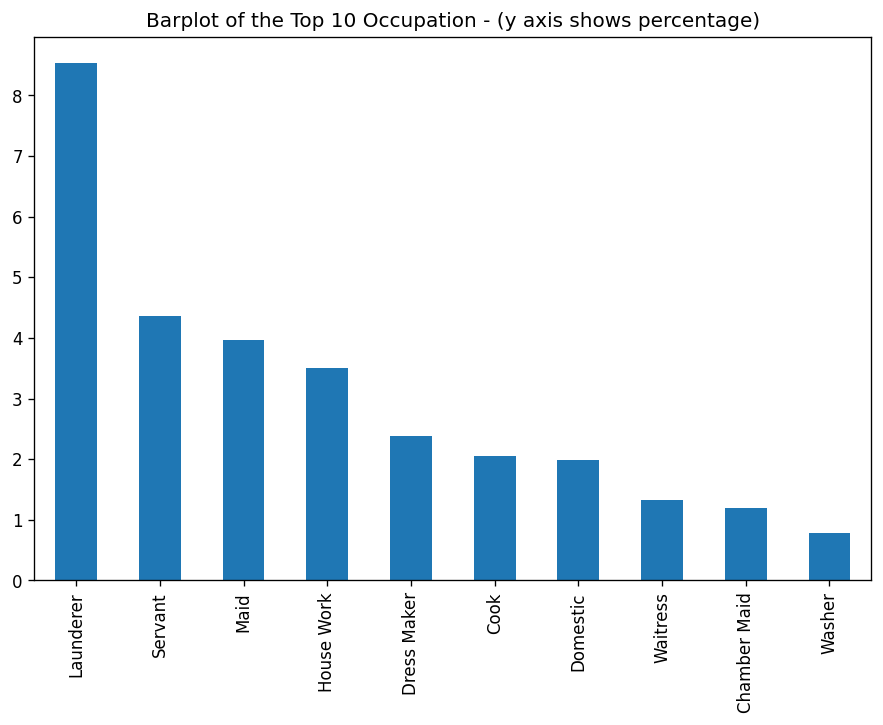

In [ ]:
describe("Occupation", data_4)